Dec 2015
<img width=300 src="./fig/ladisk.png">

<center>[izr.prof. dr. Janko Slavič](http://www.ladisk.si/~slavic)</center>


<center>[Repozitorij pypinm](http://github.com/jankoslavic/pypinm)</center>

In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import seaborn # ta paket lahko odstranite, namenjen je lepšemu izrisu
%matplotlib inline

c:\anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# 1. Uvod v reševanje dvo-točkovnih robnih pogojev

Pod dvo točkovnima robnima pogojema razumemo npr. navadno diferencialno enačbo:
$$y''=f(t, y, y'),$$
kjer so podani dodatni pogoji:
$$y(a)=\alpha\qquad\textrm{in}\qquad y(b)=\beta.$$

Za razliko od reševanja diferencialnih enačb pri začetnih vrednostih, imamo tukaj podane vrednosti pri dveh različnih časih $a$ in $b$ (v tem primeru je neodvisna spremenljivka čas, v splošnem pa ne). Metode, ki smo jih spoznali pri reševanju glede na *začetne pogoje* zato tukaj odpadejo. Lahko pa bi *ugibali začetne pogoje* in če bi z začetnimi pogoji uspeli zadostiti robne pogoje, bi našli (morebitno) rešitev. V ideji bi torej ugibali začetne pogoje in nato gledali ali smo zadeli željene robne pogoje; nato bi naredili morebitne popravke začetnih pogojev in spet gledali rezultat. Takšen iterativen pristop se imenuje **strelska metoda** (ang. *shooting method*).

Drugačen pristop predstavlja diskretizacija diferencialne enačbe s pomočjo **končnih razlik**. Na tak način diferencialno enačbo preoblikujemo na sistem algebrajskih enačb.

Oba pristopa si bomo pogledali v nadaljevanju.

# 2. Strelska metoda

Predpostavimo, da zgoraj prikazano diferencialno enačbo ($y''=f(t, y, y')$) rešijo začetni pogoji:
$$y(a)=\alpha\qquad\textrm{in}\qquad y'(a)=u.$$

Če $\theta(u)$ predstavlja rešitev diferencialne enačbe ob začetnih pogojih $y(a)=\alpha\qquad\textrm{in}\qquad y'(a)=u$, potem smo rešitev za robni pogoj našli, ko velja:
$$r(u)=\theta(u)-\beta=0.$$

Izpeljan izraz v bistvu predstavlja iskanje ničel funkcije mejnih preostankov $r(u)$.

### Primer: nadaljevanje domače naloge

Na sliki (vir: Numerical Methods in Engineering With Python 3, 3rd Ed, Jaan Kiusalaas) je prikazan izstrelek mase $m$, ki ga izstrelimo s hitrosjo $v_0$ pod kotom $\alpha$. Če je sila upora zraka: $F=c\,v^{3/2}$, potem sta gibalni enačbi:
$$\ddot x(t)=-F\,\cos(\alpha)\qquad\ddot y(t)=-F\,\sin(\alpha)-g.$$

Opomba: $v=\sqrt{\dot x^2+\dot y^2}.$ Ustrezne parametre si izmislite.
<img src="./fig/Jaan Kiusalaas stran 265 n13.png" width=300>
Določite začetne pogoje za doseganje izbranih robnih pogojev!

Najprej si poglejmo podano rešitev

In [2]:
# Paramatre si ustrezno izmislimo
v0=200
#v0=sol.x[0]
alpha = 30*np.pi/180
#alpha = sol.x[1]
dt = 0.01
y_zacetni_pogoji = np.array([0, v0*np.cos(alpha), 0, v0*np.sin(alpha)])
def F(t, y, c=0.5, g = 9.81):
    # y = [x0, x1, y0, y1]
    v = np.sqrt(y[1]**2+y[3]**2)
    F = c*v**(3/2)
    a = np.arctan2(y[3],y[1])
    return np.array([y[1], - F*np.cos(a), y[3], -F*np.sin(a) - g])

In [3]:
solver = ode(F).set_integrator('dopri5').set_initial_value(y_zacetni_pogoji)
solver.set_f_params(.5)
t_RK4_sci = [0]
x_RK4_sci = [y_zacetni_pogoji]
while solver.successful() and solver.t <= 1.:
    solver.integrate(solver.t+dt)
    t_RK4_sci.append(solver.t)
    x_RK4_sci.append(solver.y)
t_RK4_sci = np.array(t_RK4_sci)
x_RK4_sci = np.array(x_RK4_sci)

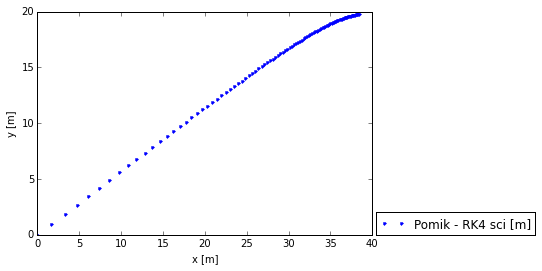

In [4]:
plt.plot(x_RK4_sci[:, 0], x_RK4_sci[:, 2], 'b.', label='Pomik - RK4 sci [m]')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(loc=(1.01, 0));

#### Primer 1a: spreminjanje začetne hitrosti za doseganje razdalje $x$

Poglejmo si vrednosti pri $t_1=1\,$s:

In [5]:
t_RK4_sci[100]

1.0000000000000007

In [6]:
x_RK4_sci[100]# x, x', y, y'

array([ 38.40067971,   8.78119139,  19.79154378,   0.83710663])

Definirajmo funkcijo mejnega preostanka:

In [7]:
def R(v0=200, alpha = 30*np.pi/180, c=0.5, t1=1, ciljni_x_pri_t1=40):
    y_zacetni_pogoji = np.array([0, v0*np.cos(alpha), 0, v0*np.sin(alpha)])
    solver = ode(F).set_integrator('dopri5').set_initial_value(y_zacetni_pogoji)
    solver.set_f_params(c)
    return solver.integrate(t1)[0]-ciljni_x_pri_t1

Poiščimo ničlo mejnega preostanka (zelo pomemben je dober začetni približek!):

In [8]:
import scipy.optimize as optimize

In [9]:
optimize.newton(R, 200)

213.94329077826208

#### Primer 1b: spreminjanje začetnih pogojev za doseganje $x$ in $\dot y$

Poglejmo si sedaj spreminjanje dveh začetnih pogojev za doseganje ciljne lege $x$ in hitrosti $\dot y$:

In [10]:
def R2(x=[200, 30*np.pi/180], c=0.5, t1=1, x_t1=40., dy_t1=-3.):
    v0, alpha =x
    y_zacetni_pogoji = np.array([0, v0*np.cos(alpha), 0, v0*np.sin(alpha)])
    solver = ode(F).set_integrator('dopri5').set_initial_value(y_zacetni_pogoji)
    solver.set_f_params(c)
    sol = solver.integrate(t1)
    return [sol[0]-x_t1, sol[3]-(dy_t1)]

In [11]:
R2()

[-1.5993161253078441, 3.8371102385904354]

In [12]:
sol = optimize.root(R2, [200, np.pi/6])

In [13]:
sol.x

array([  1.72667220e+02,   1.28159758e-01])

In [14]:
sol.x[1]*180/np.pi

7.3430132098999081

### Primer 2: nosilec z obremenitvijo

Poglejmo si primer (Numerical Methods in Engineering With Python 3, Third Ed., Jaan Kiusalaas, stran 300):
<img src='./fig/Jaan Kiusalaas stran 300 example 8.4.png' width=300>

#### Simbolna rešitev

Diferencialna enačba, ki popisuje problem je:

In [15]:
import sympy as sym
sym.init_printing()

In [16]:
v, x, EI, w0, L = sym.symbols('v, x, EI, w0, L')

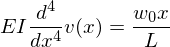

In [17]:
eq = sym.Eq(EI*v(x).diff(x,4), w0*x/L)
eq

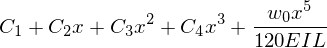

In [26]:
sol = sym.dsolve(eq).args[1]
sol

In [23]:
sol.subs(x, 0)

In [24]:
sol.diff(x, 2).subs(x, 0)

In [26]:
c1c3 = {'C1': 0, 'C3': 0}

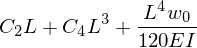

In [32]:
eq1 = sol.subs(c1c3).subs(x, L)
eq1

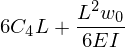

In [33]:
eq2 = sol.diff(x, 2).subs(c1c3).subs(x, L)
eq2

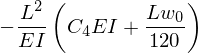

In [34]:
C2 = sym.solve(eq1, 'C2')[0]
C2

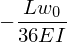

In [35]:
C4 = sym.solve(
      eq2.subs('C2', C2),
      'C4'
     )[0]
C4

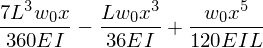

In [36]:
resitev = sol.subs(c1c3).subs('C2', C2).subs('C4', C4)
resitev

In [37]:
podatki = {EI: 2.1e11*0.4, L: 20, w0:-100e3}

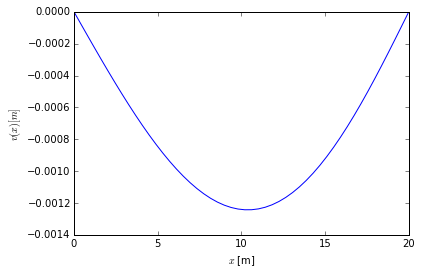

In [38]:
x_ana = np.linspace(0, podatki[L], 50)
v_ana = [resitev.subs(podatki).evalf(subs={x: _}) for _ in x_ana]
plt.plot(x_ana, v_ana)
plt.xlabel('$x$ [m]')
plt.ylabel('$v(x) [m]$');

#### Numerična rešitev

Poglejmo si sedaj numerično rešitev. Za diferencialno enačbo:

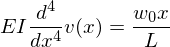

In [70]:
eq

imamo podane robne pogoje (členkasto vpet nosilec):
$$v(0)=v(L)=0\quad\textrm{in}\quad v''(0)=v''(L)=0$$

Dva začetna pogoja imamo, iščemo še dva dodatna:
$$v'(0)=u_0\quad\textrm{in}\quad v'''(0)=u_1,$$
ki bosta zadostila zgornje robne pogoje.

Mejni preostanek je torej definiran kot:

In [71]:
def R(x=[-1e-3, 1], L=20, v_L=0, ddv_L=0):
    dv, dddv = x
    y_zacetni_pogoji = np.array([0, dv, 0, dddv])
    solver = ode(F).set_integrator('dopri5').set_initial_value(y_zacetni_pogoji)   
    sol = solver.integrate(L)
    return [sol[0]-v_L, sol[2]-ddv_L]

In [94]:
def F(x, y, EI=2.1e11*0.4, L=20, w0=-100e3):
    # y = [v0, v1, v2, v3]
    return np.array([y[1], y[2], y[3], w0*x/(EI*L)])
    #return np.array([y[1], y[2], y[3], w0*(L-x)/(EI*L)])#obrnjena rampa
    #return np.array([y[1], y[2], y[3], w0*L*np.cos(np.pi*x/L)/(EI*L)]) #polsinus

In [95]:
R()

In [96]:
sol = optimize.root(R, [-1e-6, 1])
sol.x

array([ -1.85185185e-04,   3.96825397e-06])

In [97]:
R(x=sol.x)

In [98]:
def R_koraki(x=[-1e-3, 1], L=20, v_L=0, ddv_L=0, N=50):
    dv, dddv = x
    y_zacetni_pogoji = np.array([0, dv, 0, dddv])
    solver = ode(F).set_integrator('dopri5').set_initial_value(y_zacetni_pogoji)
    sol = solver.integrate(L)
    x_out = np.linspace(0, L, N)
    y_out = []
    for _ in x_out:
        solver.integrate(_)
        y_out.append(solver.y)
    return x_out, np.array(y_out)

In [99]:
x_int, v_int = R_koraki(sol.x)

In [100]:
plt.plot(x_ana, v_ana)
plt.plot(x_int, v_int[:, 0], 'r.')
plt.xlabel('$x$ [m]')
plt.ylabel('$v(x) [m]$');

# 3. Metoda končnih razlik

Ponovno si poglejmo zgornjo diferencialno enačbo četrtega reda:

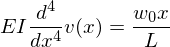

In [101]:
eq

S pomočjo centralne diferenčne sheme lahko za $i$-to točko zapišemo:
$$1\,v_{i-2} - 4\,v_{i-1} + 6\,v_{i} - 4\,v_{i+1} + 1\, v_{i+2} = \frac{h^{4}\, w_{0} x_{i}}{E\,I\,L}.$$

Če je vseh točk $n$, lahko dodatne robne pogoje pri zgornjem primeru zapišemo enačbe:
$$v_0=v(0)=0$$
in
$$v_{n-1}=v(L)=0$$

Iz preostalih robnih pogojev pa sledita enačbi:
$$v''(0)=0\qquad\rightarrow\qquad -v_{-1}+2\,v_0-v_1=0$$
in
$$v''(L)=0\qquad\rightarrow\qquad -v_{n-2}+2\,v_{n-1}-v_n=0$$

**Sledi** torej, da moramo v obravnavani sistem vpeljati dve namišljene točke $v_{-1}$ in $v_n$.

Poglejmo si v nadaljevanju numerični zgled.

#### Numerični zgled

Najprej diskretizirajmo neodvisno spremenljivko ``x_a`` (najmanjše število fizikalnih točk je 3, ob razširitvi z dvema navideznima, bomo imeli točk 5):

In [161]:
tock = 30
x_a = np.linspace(0, podatki[L], tock)
h = x_a[1]
x_a[:10]

array([ 0.        ,  0.68965517,  1.37931034,  2.06896552,  2.75862069,
        3.44827586,  4.13793103,  4.82758621,  5.51724138,  6.20689655])

ter pripravimo obremenitev ``w_a`` in vektor konstant ``b``:

In [186]:
w_a = podatki[w0]*x_a
#w_a = podatki[w0]*np.cos(np.pi*x_a/podatki[L])*np.max(x_a)
b = w_a*h**4/(podatki[EI]*podatki[L])
b[:10]

array([ -0.00000000e+00,  -9.28647101e-09,  -1.85729420e-08,
        -2.78594130e-08,  -3.71458840e-08,  -4.64323550e-08,
        -5.57188260e-08,  -6.50052970e-08,  -7.42917680e-08,
        -8.35782390e-08])

Sedaj pripravimo še matriko koeficientov; ker uporabimo centralno diferenčno shemo, nam nekaj težav povzročajo točke na robovih in ta del bomo najprej izpustili:

In [187]:
from scipy.misc import central_diff_weights as cdw
A2 = np.zeros((tock+2, tock+2))
shema4_tock = 5
shema4 = cdw(shema4_tock, 4)
shema4

array([ 1., -4.,  6., -4.,  1.])

In [188]:
for i in range(len(A2)-4):
     A2[i+2, i:i+shema4_tock] = shema4
A2

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  6., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  6., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Dodamo robna pogoja $v(0)=v(L)=0$:

In [189]:
A2[1,1] = 1
A2[-2,-2] = 1
A2

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  6., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  6., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

in še robna pogoja $v''(0)=v''(L)=0$:

In [190]:
A2[0, :3] = np.array([1, -2, 1])
A2[-1, -3:] = np.array([1, -2, 1])
A2

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  6., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  6., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

Ustrezno popravimo vektor konstant:

In [191]:
b2 = np.zeros(len(A2))
b2[2:-2] = b[1:-1]

In [192]:
b2[:10]

array([  0.00000000e+00,   0.00000000e+00,  -9.28647101e-09,
        -1.85729420e-08,  -2.78594130e-08,  -3.71458840e-08,
        -4.64323550e-08,  -5.57188260e-08,  -6.50052970e-08,
        -7.42917680e-08])

Spomnimo se, da rešujemo: 
$$\mathbf{A}_2\,\mathbf{v}=\mathbf{b}_2,$$
kjer je vektor neznanih pomikov $\mathbf{v}$. $\mathbf{A}_2$ je z dvema navideznima točkama razširjena matrika koeficientov in $\mathbf{b}_2$ razširjen vektor konstant.

In [193]:
np.linalg.cond(A2)

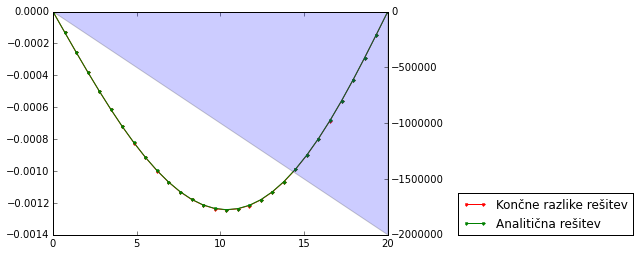

In [194]:
v_mkr = np.linalg.solve(A2, b2)[1:-1]
v_ana = [resitev.subs(podatki).evalf(subs={x: _}) for _ in x_a]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x_a, v_mkr, 'r.-', label='Končne razlike rešitev')
ax1.plot(x_a, v_ana, 'g.-', label='Analitična rešitev');
ax2.fill_between(x_a, w_a, 0, alpha=0.2)
ax1.legend(loc=(1.21,0.));

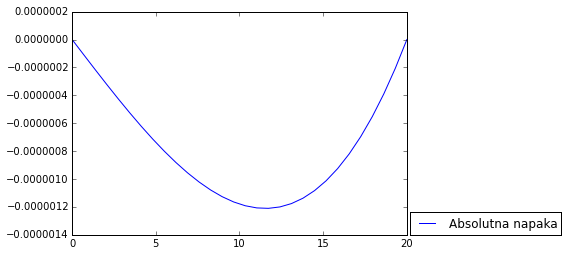

In [195]:
plt.plot(x_a, v_mkr-v_ana, label='Absolutna napaka')
plt.legend(loc=(1.01, 0));